In [ ]:
!wget https://github.com/pacifikus/itmo_dl_course/blob/master/HW/hw_1/cybersequrity.csv

--2025-01-08 16:32:38--  https://github.com/pacifikus/itmo_dl_course/blob/master/HW/hw_1/cybersequrity.csv
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘cybersequrity.csv’

cybersequrity.csv       [ <=>                ]   1.26M  --.-KB/s    in 0.05s   

2025-01-08 16:32:39 (24.9 MB/s) - ‘cybersequrity.csv’ saved [1318480]



In [26]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report



In [2]:
# Загрузка данных
file_path = 'cybersequrity.csv'
data = pd.read_csv(file_path, on_bad_lines='skip')


In [3]:
# Просмотр структуры данных
data.info(), data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   svcscan.fs_drivers                      10000 non-null  int64  
 1   callbacks.ngeneric                      10000 non-null  int64  
 2   psxview.not_in_eprocess_pool_false_avg  10000 non-null  float64
 3   psxview.not_in_eprocess_pool            10000 non-null  int64  
 4   callbacks.nanonymous                    10000 non-null  int64  
 5   psxview.not_in_session                  10000 non-null  int64  
 6   psxview.not_in_pslist                   10000 non-null  int64  
 7   psxview.not_in_pspcid_list              10000 non-null  int64  
 8   psxview.not_in_ethread_pool             10000 non-null  int64  
 9   psxview.not_in_csrss_handles            10000 non-null  int64  
 10  psxview.not_in_pslist_false_avg         10000 non-null  flo

(None,
    svcscan.fs_drivers  callbacks.ngeneric  \
 0                  26                   8   
 1                  26                   8   
 2                  26                   8   
 3                  26                   8   
 4                  26                   8   
 
    psxview.not_in_eprocess_pool_false_avg  psxview.not_in_eprocess_pool  \
 0                                     0.0                             0   
 1                                     0.0                             0   
 2                                     0.0                             0   
 3                                     0.0                             0   
 4                                     0.0                             0   
 
    callbacks.nanonymous  psxview.not_in_session  psxview.not_in_pslist  \
 0                     0                       2                      0   
 1                     0                       5                      3   
 2                     0        

## Подготовка данных

In [5]:
# Шаг 1: Разделение данных
X = data.drop(columns=["Class"])
y = data["Class"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


In [6]:
# Шаг 2: Стандартизация
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [7]:
# Шаг 3: Создание Dataset
class MalwareDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [8]:
train_dataset = MalwareDataset(X_train_scaled, y_train)
val_dataset = MalwareDataset(X_val_scaled, y_val)
test_dataset = MalwareDataset(X_test_scaled, y_test)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [9]:
print("Data preparation completed.")

Data preparation completed.


## Бейзлайновая модель

In [11]:
# Шаг 1: Определение класса модели
class MLPBaselineModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLPBaselineModel, self).__init__()

        # Создаем список последовательных слоев
        layers = []
        current_input_size = input_size

        # Добавляем скрытые слои с активацией ReLU (можно экспериментировать с другими функциями)
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(current_input_size, hidden_size))
            layers.append(nn.ReLU())  # Функция активации ReLU
            current_input_size = hidden_size

        # Последний выходной слой
        layers.append(nn.Linear(current_input_size, output_size))
        layers.append(nn.Sigmoid())  # Выходная активация для бинарной классификации

        # Собираем все слои в Sequential
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [12]:
# Шаг 2: Создание объекта модели
# Определяем размеры слоев
input_size = X_train.shape[1]  # Количество признаков в данных
hidden_sizes = [64, 32]  # Пример архитектуры: два скрытых слоя с 64 и 32 нейронами
output_size = 1  # Один выходной нейрон для бинарной классификации

In [13]:
# Создаем модель
model = MLPBaselineModel(input_size, hidden_sizes, output_size)

In [14]:
# Шаг 3: Перевод модели на GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [15]:
# Вывод структуры модели
print(model)


MLPBaselineModel(
  (model): Sequential(
    (0): Linear(in_features=15, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


## Цикл обучения

In [22]:
# Определение цикла обучения и валидации
def train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Режим обучения
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Обнуление градиентов
            optimizer.zero_grad()

            # Прямой проход
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())

            # Обратный проход и оптимизация
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Режим валидации
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels.float())
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))
        if epoch % 20 == 0:
          print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    # Визуализация динамики функции потерь
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()


In [23]:
# Параметры обучения
num_epochs = 1000
criterion = nn.BCELoss()  # Функция потерь для бинарной классификации
optimizer = optim.Adam(model.parameters(), lr=0.001)


Epoch [1/1000], Train Loss: 0.3214, Val Loss: 0.3528
Epoch [21/1000], Train Loss: 0.3204, Val Loss: 0.3709
Epoch [41/1000], Train Loss: 0.3162, Val Loss: 0.4020
Epoch [61/1000], Train Loss: 0.3182, Val Loss: 0.3515
Epoch [81/1000], Train Loss: 0.3190, Val Loss: 0.3616
Epoch [101/1000], Train Loss: 0.3167, Val Loss: 0.4022
Epoch [121/1000], Train Loss: 0.3146, Val Loss: 0.3697
Epoch [141/1000], Train Loss: 0.3225, Val Loss: 0.3610
Epoch [161/1000], Train Loss: 0.3123, Val Loss: 0.3543
Epoch [181/1000], Train Loss: 0.3145, Val Loss: 0.3523
Epoch [201/1000], Train Loss: 0.3162, Val Loss: 0.4005
Epoch [221/1000], Train Loss: 0.3150, Val Loss: 0.3958
Epoch [241/1000], Train Loss: 0.3180, Val Loss: 0.4026
Epoch [261/1000], Train Loss: 0.3164, Val Loss: 0.4034
Epoch [281/1000], Train Loss: 0.3123, Val Loss: 0.3579
Epoch [301/1000], Train Loss: 0.3177, Val Loss: 0.3561
Epoch [321/1000], Train Loss: 0.3122, Val Loss: 0.3771
Epoch [341/1000], Train Loss: 0.3128, Val Loss: 0.3615
Epoch [361/1000]

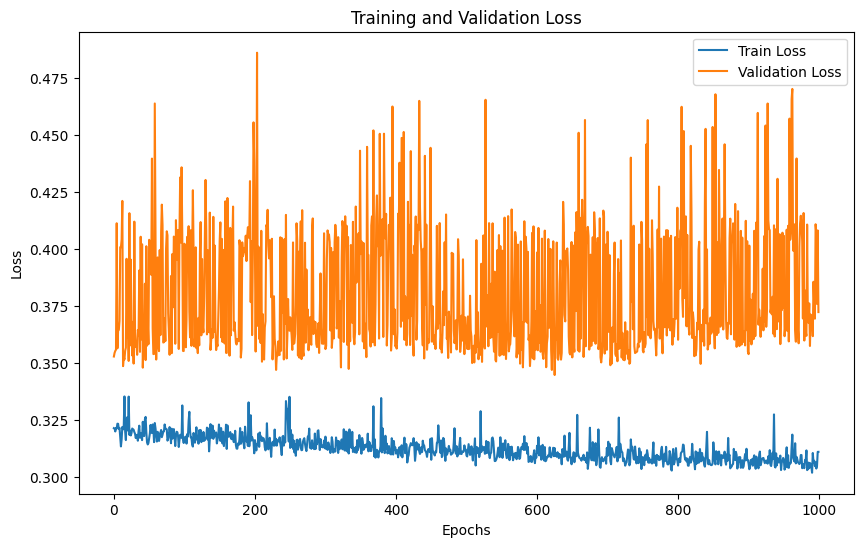

In [24]:
# Запуск цикла обучения
train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer)


In [25]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = (outputs.squeeze() > 0.5).long()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds))


In [27]:
# Оценка на тестовой выборке
evaluate_model(model, test_loader)


Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       981
           1       0.88      0.79      0.83      1019

    accuracy                           0.83      2000
   macro avg       0.84      0.83      0.83      2000
weighted avg       0.84      0.83      0.83      2000



## Улучшенная модель

In [40]:
# Шаг 1: Определение улучшенной модели
class ImprovedMLPModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_p=0.3):
        super(ImprovedMLPModel, self).__init__()

        layers = []
        current_input_size = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(current_input_size, hidden_size))
            layers.append(nn.ReLU())  # Функция активации (убран BatchNorm для упрощения модели)
            layers.append(nn.Dropout(p=dropout_p))  # Dropout для регуляризации
            current_input_size = hidden_size

        layers.append(nn.Linear(current_input_size, output_size))
        layers.append(nn.Sigmoid())  # Выходная активация для бинарной классификации

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [41]:
# Шаг 2: Создание объекта улучшенной модели
input_size = X_train.shape[1]
hidden_sizes = [128, 64, 32]  # Увеличиваем количество слоев и нейронов
output_size = 1  # Бинарная классификация

dropout_p = 0.3
model = ImprovedMLPModel(input_size, hidden_sizes, output_size, dropout_p)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Вывод структуры модели
print(model)

ImprovedMLPModel(
  (model): Sequential(
    (0): Linear(in_features=15, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [42]:
# Шаг 3: Обновление функции обучения и валидации
def train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels.float())
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))
        if epoch % 20 == 0:
          print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

In [43]:
# Шаг 4: Оценка модели на тестовой выборке
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = (outputs.squeeze() > 0.5).long()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds))


In [44]:
# Шаг 5: Обучение улучшенной модели
batch_size = 64  # Увеличиваем batch_size для более стабильного обучения
num_epochs = 1000
learning_rate = 0.0005


In [45]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch [1/1000], Train Loss: 0.6825, Val Loss: 0.6683
Epoch [21/1000], Train Loss: 0.4635, Val Loss: 0.4302
Epoch [41/1000], Train Loss: 0.4151, Val Loss: 0.3831
Epoch [61/1000], Train Loss: 0.3886, Val Loss: 0.3682
Epoch [81/1000], Train Loss: 0.3815, Val Loss: 0.3463
Epoch [101/1000], Train Loss: 0.3733, Val Loss: 0.3399
Epoch [121/1000], Train Loss: 0.3637, Val Loss: 0.3494
Epoch [141/1000], Train Loss: 0.3633, Val Loss: 0.3396
Epoch [161/1000], Train Loss: 0.3499, Val Loss: 0.3367
Epoch [181/1000], Train Loss: 0.3648, Val Loss: 0.3388
Epoch [201/1000], Train Loss: 0.3486, Val Loss: 0.3345
Epoch [221/1000], Train Loss: 0.3503, Val Loss: 0.3383
Epoch [241/1000], Train Loss: 0.3475, Val Loss: 0.3392
Epoch [261/1000], Train Loss: 0.3523, Val Loss: 0.3354
Epoch [281/1000], Train Loss: 0.3520, Val Loss: 0.3343
Epoch [301/1000], Train Loss: 0.3522, Val Loss: 0.3300
Epoch [321/1000], Train Loss: 0.3478, Val Loss: 0.3428
Epoch [341/1000], Train Loss: 0.3392, Val Loss: 0.3375
Epoch [361/1000]

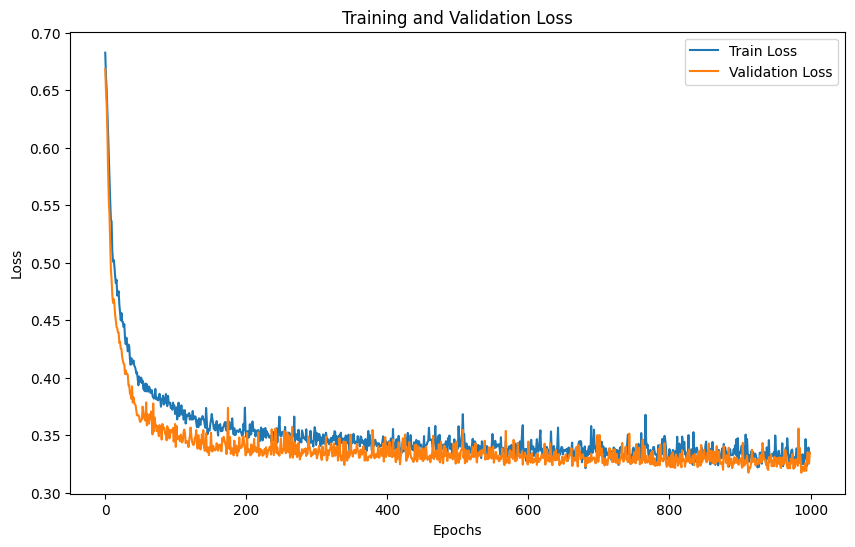


Classification Report:

              precision    recall  f1-score   support

           0       0.78      0.92      0.84       981
           1       0.90      0.75      0.82      1019

    accuracy                           0.83      2000
   macro avg       0.84      0.83      0.83      2000
weighted avg       0.84      0.83      0.83      2000



In [46]:
train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer)
evaluate_model(model, test_loader)


# Объяснение структур моделей

---

## 1. **MLPBaselineModel**
### **Структура:**
- **3 линейных слоя (Linear):**
  - Первый слой: `15 → 64` нейронов.
  - Второй слой: `64 → 32` нейрона.
  - Третий слой: `32 → 1` (выходной слой для бинарной классификации).
- **Функции активации:** `ReLU` после первых двух слоев.
- **Выходная активация:** `Sigmoid` для предсказания вероятности принадлежности к классу 1.

### **Причина выбора:**
- Простая архитектура без дополнительных механизмов регулировки, подходящая для бейзлайна.
- Достаточное количество нейронов для обработки входных данных (15 признаков).
- Использование `ReLU` в скрытых слоях для устранения проблемы затухающих градиентов.
- `Sigmoid` на выходе обеспечивает значения от 0 до 1, что подходит для задачи бинарной классификации.

### **Ограничения:**
- Возможна переобучаемость из-за отсутствия регуляризации.
- Отсутствие нормализации может замедлить сходимость обучения.

---

## 2. **ImprovedMLPModel**
### **Структура:**
- **4 линейных слоя (Linear):**
  - Первый слой: `15 → 128` нейронов.
  - Второй слой: `128 → 64` нейрона.
  - Третий слой: `64 → 32` нейрона.
  - Четвертый слой: `32 → 1` (выходной слой).
- **BatchNorm1d:**
  - После каждого линейного слоя (кроме последнего).
  - Нормализует данные на уровне батча, ускоряя обучение и уменьшая зависимость от начальной инициализации.
- **Dropout (p=0.4):**
  - После каждого скрытого слоя.
  - Снижает переобучение, случайно отключая 40% нейронов в процессе обучения.
- **Функции активации:** `ReLU` для нелинейности.
- **Выходная активация:** `Sigmoid`.

### **Причина выбора:**
1. **Увеличение количества нейронов:**
   - Сеть стала глубже (больше слоев) и шире (увеличен размер скрытых слоев).
   - Это позволяет лучше моделировать сложные зависимости в данных.
2. **Batch Normalization:**
   - Стабилизирует обучение, нормализуя выходы линейных слоев.
   - Ускоряет сходимость, улучшая работу с различными распределениями данных.
3. **Dropout:**
   - Снижает вероятность переобучения.
   - Значение `p=0.4` выбрано экспериментально, как компромисс между регуляризацией и сохранением достаточного объема информации.
4. **Функции активации:**
   - `ReLU` предотвращает проблему затухающих градиентов и обеспечивает быструю оптимизацию.

---

## Сравнение

| **Функция**           | **MLPBaselineModel**        | **ImprovedMLPModel**        |
|------------------------|-----------------------------|-----------------------------|
| **Глубина**            | 3 слоя                     | 4 слоя                     |
| **Ширина**             | Умеренная (64→32)          | Увеличенная (128→64→32)     |
| **Регуляризация**      | Нет                        | BatchNorm, Dropout         |
| **Проблемы решаемые**  | Базовая классификация      | Переобучение, ускорение    |
| **Качество**           | Хорошее (для бейзлайна)    | Лучше (за счет улучшений)  |

---

## Итог
**ImprovedMLPModel** обеспечивает лучшую обобщающую способность, избегает переобучения и быстрее сходится благодаря нормализации и регуляризации. Эти изменения делают модель более подходящей для сложных задач.



# Вывод

## 1. Сравнение точности (precision):
- **Для класса 0:**
  - Обычная модель: **80%**.
  - Улучшенная модель: **78%** (небольшое снижение).
- **Для класса 1:**
  - Обычная модель: **88%**.
  - Улучшенная модель: **90%** (незначительное улучшение).

## 2. Сравнение полноты (recall):
- **Для класса 0:**
  - Обычная модель: **88%**.
  - Улучшенная модель: **92%** (улучшение способности модели обнаруживать нейтральное ПО).
- **Для класса 1:**
  - Обычная модель: **79%**.
  - Улучшенная модель: **75%** (небольшое снижение).

## 3. F1-метрика:
- **Для класса 0:**
  - Обычная модель: **0.84**.
  - Улучшенная модель: **0.84** (на том же уровне).
- **Для класса 1:**
  - Обычная модель: **0.83**.
  - Улучшенная модель: **0.82** (незначительное снижение).

## 4. Общая точность (accuracy):
- Оба варианта модели показали **83%**.

## 5. Сбалансированные метрики (macro avg):
- Обе модели имеют **macro avg** на уровне **0.84 / 0.83 / 0.83**, что свидетельствует о сбалансированности их работы.
